## Loading Libraries

In [ ]:
# from google import colab
# colab.drive.mount('/content/drive')
# import os

# os.chdir('/content/drive/My Drive/TikTok Hackathon/data gzip')

Mounted at /content/drive


User guide:

If you wish to see model performance only, please refer to Section: **Baseline Feature Engineering + Model**, under **Model Training**;

If you wish to run the model on a separated test dataset, please go to ****Baseline Feature Engineering + Model**, under **Loading Training Data**, simply replace the file path with your target filepath. Note that the algorithm assumes that the data must has the column`'text'`, which contains review content in strings; and the column `'rating'`, with integer 1 to 5 as inputs.

If you wish to run this baseline model on a separte dataset, please go to **Deploying the Baseline Model** and follow the steps.

In [ ]:
import pandas as pd
import re
import spacy
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Baseline Feature Engineering + Model
This section documents how we create our baseline model for feature selection and pipeline prototyping. The relevant output from previous runs are displayed below.

### Loading training data

In [ ]:
# read in our sample training data, conduct train-test split
df = pd.read_parquet("tokenized_training_data.parquet")
X = df[["text", "rating"]]
y = df['category'] #categories: ["relevant review", "advertisement / spam", "no first-hand experience", "irrelevant / off-topic"]
y_simple = df['label'] #labels: ["relevant", "irrelevant"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [ ]:
def clean_df(review_df):
    # preserve only rating/text
    columns_to_keep = ['rating', 'text']
    review_df = review_df.loc[:, columns_to_keep].copy()

    # remove empty reviews
    review_df = review_df[review_df['text'].notna()]

    # remove new line symbols
    review_df["text"] = review_df["text"].str.replace(r"[\r\n]+", ". ", regex=True)

    # remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    review_df["text"] = review_df["text"].str.replace(emoji_pattern, "", regex=True)

    # Extract translated text if present
    pattern = r"\(Translated by Google\) (.*?) \(Original\)"
    review_df["text"] = review_df["text"].str.extract(pattern)[0].fillna(review_df["text"])

    # remove special characters
    review_df["text"] = review_df["text"].str.replace(r"[^a-zA-Z0-9\s\.\!\?\,]", "", regex=True)

    return review_df

def extract_numeric_features(review_df):
    # first clean the raw dataframe
    review_df = clean_df(review_df)

    # ensure text column has no missing values
    review_df['text'] = review_df['text'].fillna('')

    # compute numeric features
    review_df['review_length'] = review_df['text'].apply(len)
    review_df['num_words'] = review_df['text'].apply(lambda x: len(x.split()))
    review_df['num_urls'] = review_df['text'].apply(lambda x: len(re.findall(r"http\S+|www\S+", x)))
    review_df['num_exclamations'] = review_df['text'].apply(lambda x: x.count('!'))
    review_df["num_questions"] = review_df["text"].str.count(r"\?")
    review_df["num_upper"] = review_df["text"].apply(lambda x: sum(1 for w in x.split() if w.isupper()))
    review_df["num_phone"] = review_df["text"].str.count(r"\d{6,}")

    numeric_features = review_df[['review_length', 'num_words', 'num_urls', 'num_exclamations',
                                  'num_questions', 'num_upper', 'num_phone']].values
    return numeric_features, review_df  # also return cleaned df for further use

def fit_vectorizor(X_train):
  # TF-IDF textual features
  vectorizer = TfidfVectorizer(max_features=5000)# could experiment with ngram_range=(1,2) also, compare performance
  # X_train_text = X_train['tokens'].apply(lambda tokens: " ".join(tokens))
  X_text = vectorizer.fit(X_train['text'])
  return vectorizer

def vectorize(vectorizer, X_train):
  # X_train_text = X_train['tokens'].apply(lambda tokens: " ".join(tokens))
  X_text = vectorizer.transform(X_train['text'])
  return X_text


In [ ]:
# Feature engineering from tokenized data

X_train_numeric, X_train_cleaned = extract_numeric_features(X_train)
# Vectorize text
vectorizor = fit_vectorizor(X_train_cleaned)
X_train_text = vectorize(vectorizor, X_train_cleaned)
# Combine numeric + text
X_train_feature = hstack([X_train_text, X_train_numeric])

# Feature selection using Logistic Regression with L1 penalty
# This will keep only the features that are most predictive of the label
selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
selector.fit(X_train_feature, y_train)
X_train_selected = selector.transform(X_train_feature)

# Transform test data
X_test_numeric, X_test_cleaned = extract_numeric_features(X_test)
X_test_text = vectorize(vectorizor, X_test_cleaned)
X_test_feature = hstack([X_test_text, X_test_numeric])
X_test_selected = selector.transform(X_test_feature)

In [ ]:
X_test_selected

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1804 stored elements and shape (239, 94)>

### Model training
Scale numerical features

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


In [ ]:
X_train_scaled

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7268 stored elements and shape (956, 94)>

Train SVM

In [ ]:
import numpy as np
from sklearn.svm import LinearSVC
# SVM
svm = LinearSVC(max_iter=5000)
svm.fit(X_train_scaled, y_train)


LinearSVC(max_iter=5000)

Train Logistics Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

Compare the model performance for training set

In [ ]:

y_pred_log = clf.predict(X_train_scaled)
y_pred_svm = svm.predict(X_train_scaled)

print("=== Logistic Regression ===")
print("\nClassification Report:\n")
print(classification_report(y_train, y_pred_log))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_train, y_pred_log))

print("=== SVM ===")
print("\nClassification Report:\n")
print(classification_report(y_train, y_pred_svm))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_train, y_pred_svm))

=== Logistic Regression ===

Classification Report:

                          precision    recall  f1-score   support

                ads_spam       0.99      1.00      1.00       155
              irrelevant       1.00      0.99      0.99       159
no first-hand experience       1.00      1.00      1.00       161
         relevant review       1.00      1.00      1.00       481

                accuracy                           1.00       956
               macro avg       1.00      1.00      1.00       956
            weighted avg       1.00      1.00      1.00       956


Confusion Matrix:

[[155   0   0   0]
 [  0 157   0   2]
 [  0   0 161   0]
 [  1   0   0 480]]
=== SVM ===

Classification Report:

                          precision    recall  f1-score   support

                ads_spam       0.99      1.00      1.00       155
              irrelevant       1.00      0.99      0.99       159
no first-hand experience       1.00      1.00      1.00       161
         relevant

Compare the model performance for testing set

In [ ]:
y_pred_log_test = clf.predict(X_test_scaled)
y_pred_svm_test = svm.predict(X_test_scaled)

print("=== Logistic Regression ===")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_log_test))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_log_test))

print("=== SVM ===")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_svm_test))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_svm_test))

=== Logistic Regression ===

Classification Report:

                          precision    recall  f1-score   support

                ads_spam       0.96      1.00      0.98        45
              irrelevant       0.95      0.95      0.95        41
no first-hand experience       1.00      1.00      1.00        39
         relevant review       0.98      0.96      0.97       114

                accuracy                           0.97       239
               macro avg       0.97      0.98      0.98       239
            weighted avg       0.98      0.97      0.97       239


Confusion Matrix:

[[ 45   0   0   0]
 [  0  39   0   2]
 [  0   0  39   0]
 [  2   2   0 110]]
=== SVM ===

Classification Report:

                          precision    recall  f1-score   support

                ads_spam       0.96      1.00      0.98        45
              irrelevant       0.97      0.95      0.96        41
no first-hand experience       1.00      1.00      1.00        39
         relevant

### Performance Analysis

The precision, recall and F1-score are all exceptionally high in both models, which suggests overfitting issues. It could be due to the small sample size of our training data. Additionally, since the data we obtained is highly imbalanced, we applied upsampling methods by duplication, and this might have resulted in high resemblance in the training and testing data, therefore the extremely high test precision and accuracy.

Initialise the baseline model with a high-quality and balanced data set would probably yield more realistic baseline model.

### Model Archiving

In [ ]:
import joblib

# Save components for future use
joblib.dump(vectorizor, "tfidf_vectorizor.joblib")
joblib.dump(scaler, "numeric_scaler.joblib")
joblib.dump(svm, "svm_model.joblib")
joblib.dump(clf, "logreg_model.joblib")  # optional

['logreg_model.joblib']

## Deploying the Baseline Model
The baseline model could be further used for efficient ground-truth labelling in a larger scale.

This part attempts to run the baseline model trained in a larger scale to obtain more ground truth labels.

Firstly, read in the larger raw dataset. And load the saved models and components.

To test run, for `combined_sample`, replace the filepath with your desired filepath, run all code chunks in order.

In [ ]:
# Replace with own raw data file path/type
combined_sample = pd.read_json("combined_sample.json.gz", compression="gzip", lines=True)

In [ ]:
# Later, load them
vectorizer = joblib.load("tfidf_vectorizer.joblib")
scaler = joblib.load("numeric_scaler.joblib")
svm = joblib.load("svm_model.joblib")
clf = joblib.load("logreg_model.joblib")

The following function runs the Logistics Regression and SVM baseline models on the raw dataset to obtain two set of classifier labels (`logreg_label`,`svm_label`) and the logistics regression confidence score (`logreg_conf`) for reference.

In [ ]:
def label_new_data(new_df):
    # Clean & extract numeric features
    X_numeric, X_cleaned = extract_numeric_features(new_df)

    # Vectorize text
    X_text = vectorize(vectorizor, X_cleaned)

    # Combine numeric + text features
    X_feature = hstack([X_text, X_numeric])

    # Apply feature selection
    X_selected = selector.transform(X_feature)

    # Scale features
    X_scaled = scaler.transform(X_selected)

    # Predictions
    logreg_pred = clf.predict(X_scaled)
    logreg_conf = clf.predict_proba(X_scaled).max(axis=1)
    svm_pred = svm.predict(X_scaled)

    # Add results to DataFrame
    X_cleaned['logreg_label'] = logreg_pred
    X_cleaned['logreg_conf'] = logreg_conf
    X_cleaned['svm_label'] = svm_pred

    return X_cleaned

Run the function to obtain the labeled data

In [ ]:
labeled_sample = label_new_data(combined_sample)
labeled_sample.tail()

,rating,text,review_length,num_words,num_urls,num_exclamations,num_questions,num_upper,num_phone,logreg_label,logreg_conf,svm_label
242257,5,"Very nice place with great views, lots of plac...",55,11,0,0,0,0,0,relevant review,0.999582,relevant review
242258,5,I love this place! The palm trees and lighting...,290,56,0,1,0,1,0,relevant review,0.999988,relevant review
242259,5,"We took the tour, it was a very cool place to ...",59,14,0,0,0,0,0,relevant review,1.000000,relevant review
242262,5,"Probably, the best museum in the NYC.",37,7,0,0,0,1,0,relevant review,0.962054,relevant review
242263,5,"Going late evening was great, empty and had th...",77,14,0,0,0,0,0,relevant review,0.999989,relevant review


Plot the category counts and confidence score distributions to explore the labeled dataset.

1.   Since 99% of the dataset are labeled "relevant review", they are removed from the graph representations for better scaling.
2.   For the 2 count plots, only reviews achieving `logreg_conf`$> 0.9$ are displayed in the graph.

In [ ]:
def plot_label_distributions(labeled_df):
    """
    Plot label distributions for Logistic Regression and SVM (high-confidence only),
    and the confidence distribution for Logistic Regression (all entries except 'relevant review').

    Parameters:
    - labeled_df: pd.DataFrame with columns 'logreg_label', 'svm_label', and 'logreg_conf'
    """
    exclude_label = 'relevant review'

    # Filter out 'relevant review' entries
    df_filtered = labeled_df[
        (labeled_df['logreg_label'] != exclude_label) &
        (labeled_df['svm_label'] != exclude_label)
    ]

    # Further filter for high-confidence for count plots
    df_high_conf = df_filtered[df_filtered['logreg_conf'] > 0.9]

    # Logistic Regression label distribution (high-confidence only)
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_high_conf, x='logreg_label', order=df_high_conf['logreg_label'].value_counts().index)
    plt.title("Logistic Regression Label Distribution (High Confidence, Excluding 'relevant review')")
    plt.ylabel("Count")
    plt.xlabel("Category")
    plt.show()

    # SVM label distribution (high-confidence only)
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_high_conf, x='svm_label', order=df_high_conf['svm_label'].value_counts().index)
    plt.title("SVM Label Distribution (High Confidence, Excluding 'relevant review')")
    plt.ylabel("Count")
    plt.xlabel("Category")
    plt.show()

    # Logistic Regression confidence distribution (all filtered entries)
    plt.figure(figsize=(6,4))
    sns.histplot(df_filtered['logreg_conf'], bins=20, kde=True)
    plt.title("Logistic Regression Confidence Score Distribution (Excluding 'relevant review')")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.show()


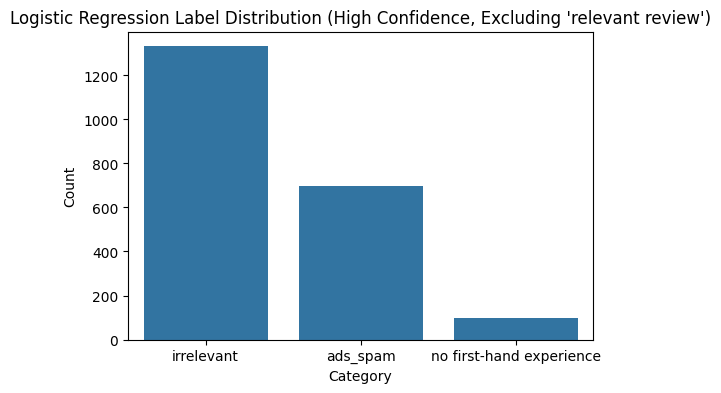

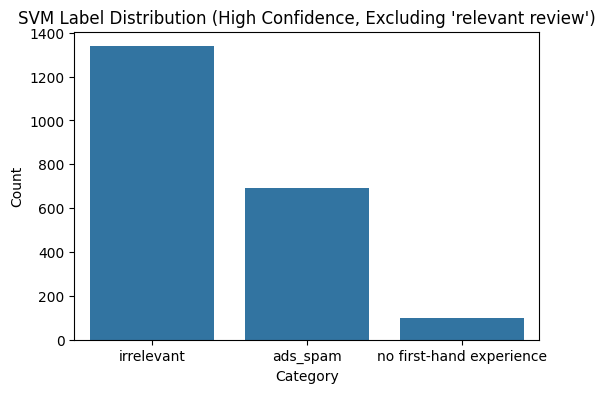

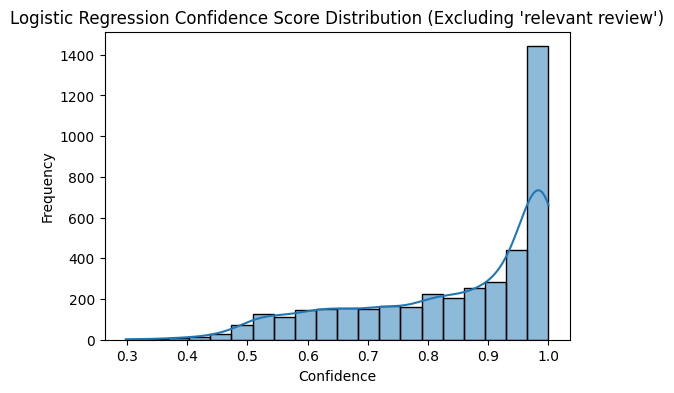

In [ ]:
plot_label_distributions(labeled_sample)

In [ ]:
# Optionally, print out some labeled reviews for manual checking


# # Define the categories you want to inspect
# categories_to_check = ['irrelevant', 'ads_spam', 'no first-hand experience']

# # Filter dataset for these categories
# filtered_reviews = labeled_sample[
#     (labeled_sample['logreg_label'].isin(categories_to_check)) &
#     (labeled_sample['logreg_conf'] > 0.9) &
#     (labeled_sample['svm_label'] == labeled_sample['logreg_label'])
# ]

# # Print out some examples for each category
# for category in categories_to_check:
#     print(f"\n=== {category.upper()} REVIEWS ===\n")
#     reviews_in_category = filtered_reviews[filtered_reviews['logreg_label'] == category]['text']
#     for i, review in enumerate(reviews_in_category.head(5), start=1):  # show first 5 examples per category
#         print(f"{i}. {review}\n")

## Model Finetuning

In [ ]:
!pip install torch transformers datasets sklearn

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Prepare data for fine-tuning

## Finetune Transformer Classifier

Use a small Gemini or Qwen variant (replace "small-gemini" with the actual small variant you downloaded).

Assume binary classification for simplicity; you can expand to 3 labels for spam/irrelevant/rants.

In [ ]:
model_name = "small-gemini"  # replace with actual local model path
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 classes


tokenize for pytorch

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Split your labeled dataset into train/validation
X_train_texts, X_val_texts, y_train, y_val = train_test_split(texts, labels, test_size=0.1, random_state=42)

train_dataset = ReviewDataset(X_train_texts, y_train, tokenizer)
val_dataset = ReviewDataset(X_val_texts, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


Pytorch training loops

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")


## Hybrid Spam filter Integration

## Evaluation and Error Analysis

## Pipeline Packaging